# Imports

In [1]:
import os
while 'pythonfigures' not in os.listdir():
    os.chdir('..')

In [2]:
from pythonfigures.datapartition import DataPartitioner
from pythonfigures.neuraldatabase import Query
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from scipy.linalg import subspace_angles, null_space, orth

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

from typing import Optional

import re

# Step 1: active-passive & visuomotor indices (forget about congruence)

In [3]:
# a string parser
def mysplit(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head, tail

animal,_ = mysplit('Zara64')
print(animal)

Zara


In [4]:
# set up a list of data-getters
# note: ignore Zara68. It's got too few units and is too temporally close to Zara70 in any case
sessions  = ['Zara64','Zara70','Moe46','Moe50']
areas     = ['AIP','F5','M1']

apidict = dict()
vmidict = dict()

for session in sessions:
    # actually, we made the decision to pool animals. neat!
    # animal,_ = mysplit(session)
    for area in areas:
        print(f'{session} {area}')
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['cue onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','object','grip','alignment'])
        
        
        
        # get passive-active indices
        df         = dp.readQuery({'context','alignment','grip'})
        df_active  = df[(df['alignment']=='hold onset') & (df['context']=='active')]
        df_passive = df[(df['alignment']=='hold onset') & (df['context']=='passive')]
        
        active_range   = df_active[dp.get('neuronColumnNames')].max() - df_active[dp.get('neuronColumnNames')].min()
        passive_range  = df_passive[dp.get('neuronColumnNames')].max() - df_passive[dp.get('neuronColumnNames')].min()
        
        API            = (active_range - passive_range) / (active_range + passive_range)
        
        if area not in apidict:
            apidict[area] = API.add_suffix(f"_{session}_{area}")
        else:
            apidict[area] = pd.concat((apidict[area],API.add_suffix(f"_{session}_{area}")))
            
        # get visuomotor indices
        df         = dp.readQuery({'context','alignment','object'})
        df_visual  = df[(df['alignment']=='cue onset') & (df['context']=='active')]
        df_motor   = df[(df['alignment']=='hold onset') & (df['context']=='active')]
        
        visual_range   = df_visual[dp.get('neuronColumnNames')].max() - df_visual[dp.get('neuronColumnNames')].min()
        motor_range    = df_motor[dp.get('neuronColumnNames')].max() - df_motor[dp.get('neuronColumnNames')].min()
        
        VMI            = (visual_range - motor_range) / (visual_range + motor_range)
        
        if area not in vmidict:
            vmidict[area] = VMI.add_suffix(f"_{session}_{area}")
        else:
            vmidict[area] = pd.concat((vmidict[area],VMI.add_suffix(f"_{session}_{area}")))

Zara64 AIP
Zara64 F5
Zara64 M1
Zara70 AIP
Zara70 F5
Zara70 M1
Moe46 AIP
Moe46 F5
Moe46 M1
Moe50 AIP
Moe50 F5
Moe50 M1


                    API       VMI area
n0_Zara64_AIP -0.234749 -0.505858  AIP
n1_Zara64_AIP -0.090018 -0.302582  AIP
n2_Zara64_AIP  0.199991 -0.235940  AIP
n3_Zara64_AIP -0.102403  0.443993  AIP
n4_Zara64_AIP -0.149164 -0.197767  AIP
...                 ...       ...  ...
n159_Moe50_M1 -0.183881 -0.330093   M1
n160_Moe50_M1 -0.954784  0.333299   M1
n161_Moe50_M1 -0.032158  0.200754   M1
n162_Moe50_M1 -0.372312 -0.020208   M1
n163_Moe50_M1  0.482623 -0.660278   M1

[1632 rows x 3 columns]


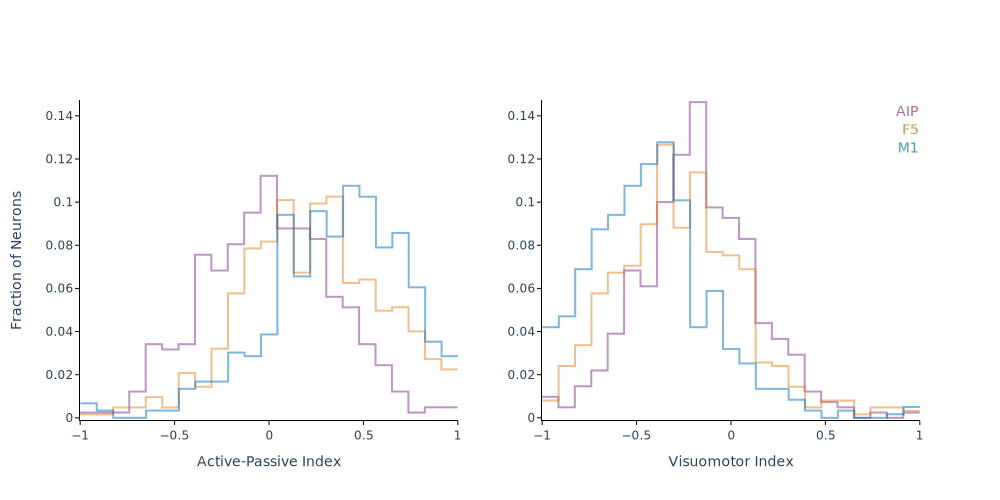

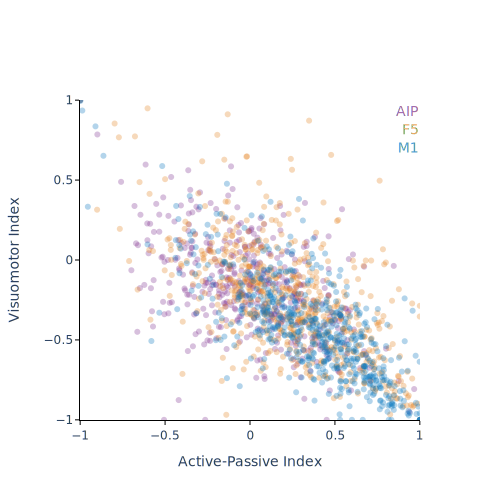

In [5]:
# now plot!
df_list = []
for area in areas:
    api = apidict[area]
    vmi = vmidict[area]
    
    df_list += [pd.DataFrame({'API':api,'VMI':vmi,'area':[area for x in range(len(api))]})]
    
dfcombo = pd.concat( tuple(df_list) )
print(dfcombo)

histhandle = make_subplots(rows=1,cols=2)
colors = pd.read_csv(os.path.join('pythonfigures','colors.csv'))
shift = -.001
maxfreq = 0
for area in areas:
    df_ = dfcombo[dfcombo['area']==area]
    api     = df_['API'].to_numpy()
    vmi     = df_['VMI'].to_numpy()
    bedges  = np.linspace(-1,1,24)
    apihist,_ = np.histogram(api,bins=bedges)
    vmihist,_ = np.histogram(vmi,bins=bedges)
    
    maxfreq = max(maxfreq,max(apihist/sum(apihist)),max(vmihist/sum(vmihist)))
    
    c  = colors[colors["Area"]==area].to_numpy()
    c  = c[0][:3]
    
    # API histogram
    histhandle.add_trace(
        go.Scatter(
            x=bedges+shift,
            y=np.append(apihist/sum(apihist),apihist[-1]/sum(apihist)),
            name=area,
            line={
                'color':f'rgba({c[0]},{c[1]},{c[2]},0.5)',
                'shape':'hv'
            },
        ),
        row=1,
        col=1
    )
    
    # VMI histogram
    histhandle.add_trace(
        go.Scatter(
            x=bedges+shift,
            y=np.append(vmihist/sum(vmihist),vmihist[-1]/sum(vmihist)),
            name=area,
            line={
                'color':f'rgba({c[0]},{c[1]},{c[2]},0.5)',
                'shape':'hv'
            },
        ),
        row=1,
        col=2
    )
    
    shift+=.001

    
# pop back out of the loop
histhandle.update_xaxes(ticks='outside',
                           tickwidth=1,
                           tickcolor='black',
                           ticklen=4,
                           linecolor='rgba(0,0,0,1)',
                           linewidth=1)

histhandle.update_yaxes(ticks='outside',
                               tickwidth=1,
                               tickcolor='black',
                               ticklen=4,
                               linecolor='rgba(0,0,0,1)',
                               linewidth=1
                               )

# guess I gotta go low-level for this
histhandle['layout']['xaxis']['title'] = 'Active-Passive Index'
histhandle['layout']['xaxis2']['title'] = 'Visuomotor Index'
histhandle['layout']['yaxis']['range'] = [-0.001,maxfreq+0.001]
histhandle['layout']['yaxis2']['range'] = [-0.001,maxfreq+0.001]

histhandle.update_layout(
    yaxis_title='Fraction of Neurons',
    plot_bgcolor='rgba(0,0,0,0)' ,
    paper_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    autosize=False,
    width=1000,
    height=500
)

# I also need to do janky things to make a custom legend, too! wow!
prepend=''
for area in areas:
    c  = colors[colors["Area"]==area].to_numpy()
    c  = c[0][:3]

    histhandle.add_annotation(xref='x domain',
                                     yref='y domain',
                                     x = 1,
                                     y = 1,
                                     text = prepend+area,
                                     showarrow=False,
                                     font={
                                         'color':f'rgba({c[0]},{c[1]},{c[2]},0.7)',
                                         'size':14
                                         },
                                     align='right',
                                     valign='top',
                                     yanchor='top',
                                     xanchor='right',
                                     row=1,
                                     col=2)

    prepend+=' <br>' # needs a space


histhandle.show(renderer="svg")

# now one more scatterplot
scatterhandle = make_subplots(rows=1,cols=1)
for area in areas:
    c  = colors[colors["Area"]==area].to_numpy()
    c  = c[0][:3]
    
    df_ = dfcombo[dfcombo['area']==area]
    api     = df_['API'].to_numpy()
    vmi     = df_['VMI'].to_numpy()
    
    scatterhandle.add_trace(
        go.Scatter(
            x=api,
            y=vmi,
            name=area,
            mode='markers',
            line={
                'color':f'rgba({c[0]},{c[1]},{c[2]},0.3)',
            }
        ),
        row=1,
        col=1
    )
    
# pop back out of the loop
scatterhandle.update_xaxes(ticks='outside',
                           tickwidth=1,
                           tickcolor='black',
                           ticklen=4,
                           linecolor='rgba(0,0,0,1)',
                           linewidth=1)

scatterhandle.update_yaxes(ticks='outside',
                               tickwidth=1,
                               tickcolor='black',
                               ticklen=4,
                               linecolor='rgba(0,0,0,1)',
                               linewidth=1
                               )

# guess I gotta go low-level for this
scatterhandle['layout']['xaxis']['title'] = 'Active-Passive Index'
scatterhandle['layout']['xaxis']['range'] = [-1.001,1.001]
scatterhandle['layout']['yaxis']['title'] = 'Visuomotor Index'
scatterhandle['layout']['yaxis']['range'] = [-1.001,1.001]

scatterhandle.update_layout(
    plot_bgcolor='rgba(0,0,0,0)' ,
    paper_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    autosize=False,
    width=500,
    height=500
)

# I also need to do janky things to make a custom legend, too! wow!
prepend=''
for area in areas:
    c  = colors[colors["Area"]==area].to_numpy()
    c  = c[0][:3]

    scatterhandle.add_annotation(xref='x domain',
                                     yref='y domain',
                                     x = 1,
                                     y = 1,
                                     text = prepend+area,
                                     showarrow=False,
                                     font={
                                         'color':f'rgba({c[0]},{c[1]},{c[2]},0.7)',
                                         'size':14
                                         },
                                     align='right',
                                     valign='top',
                                     yanchor='top',
                                     xanchor='right',
                                     row=1,
                                     col=1)

    prepend+=' <br>' # needs a space
    
scatterhandle.show(renderer="svg")

# no evidence of clustering here!
# that said, we probably won't be using this plot
# even though it fits perfectly with the story...

# Step 2: Perform orthogonalization and verify it behaves correctly

In [6]:
# intermission: import your ML Buddy
# nevermind it'll take too long!

# remember: keep it simple!
# just show you can abolish cross-classification with the visual period
# while ALSO preserving within-context grip classification accuracy!

In [7]:
orthocounts = dict()
for session in sessions:
    orthocounts[session] = dict()
    for area in areas:
        print(f"{session} {area}")
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['cue onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','object','grip','turntable','alignment'])
        
        df = dp.readQuery(0)

        df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
        labels             = df_vision_trials.index.get_level_values(0)

        flag          = False
        axesToRemove  = 0
        neurcount     = len(dp.get('neuronColumnNames'))
        pccount       = 30
        nsplits       = 5

        skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
        splits  = skf.split(np.zeros(len(labels)),labels)
        splits  = list(splits) # store as list to allow it to be used many of time
        PCmdls  = []
        deltamu = []

        # step 1: find the set of axes for each split
        for train_,_ in splits:
            df_vision_agg = df_vision_trials.iloc[train_].groupby(level=[0]).aggregate('mean')
            n_components = min(df_vision_agg.shape) - 1
            PCmdl = PCA(n_components=n_components)
            PCmdl.fit(df_vision_agg.to_numpy())
            PCmdls+=[PCmdl]

            # no delta-mus needed

        # step 2: iterate model fitting
        maxAxesToRemove = PCmdls[0].n_components_
        while not flag:
            correct_count = 0
            chance_count  = 0
            total_count   = len(labels)

            for fold,(train_,test_) in enumerate(splits):
                trainX = df_vision_trials.iloc[train_]
                trainy = labels[train_].to_numpy()

                testX  = df_vision_trials.iloc[test_]
                testy  = labels[test_].to_numpy()

                if axesToRemove > 0:
                    nullSpace = null_space( np.matrix(PCmdls[fold].components_[:axesToRemove,:]) )
                else:
                    nullSpace = np.eye(neurcount)

                # projections
                trainX = trainX.to_numpy() @ nullSpace
                testX  = testX.to_numpy() @ nullSpace

                # no deltamu to get rid of

                # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
                PCmdl = PCA(n_components=pccount)
                trainX = PCmdl.fit_transform(trainX)
                testX  = PCmdl.transform(testX)

                # now we can finally start classifying!
                LDmdl = LDA()
                LDmdl.fit(trainX,trainy)
                yhat = LDmdl.predict(testX)

                correct_count += np.sum(yhat==testy)
                chance_count  += len(testy) * max(LDmdl.priors_)

            correct_rate   = correct_count / total_count
            chance_rate    = chance_count / total_count
            threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE

            print(f"    Removed axes = {axesToRemove}")
            print(f"    Accuracy = {correct_rate}")
            print(f"    Chance = {chance_rate}")
            print(f"    Threshold = {threshold_rate}")
            print()

            if correct_rate > threshold_rate and axesToRemove<maxAxesToRemove:
                axesToRemove+=1
            else:
                flag = True

        print(f"    Final result: remove {axesToRemove} axes")
        print()
        print()
        
        orthocounts[session][area] = axesToRemove

Zara64 AIP
    Removed axes = 0
    Accuracy = 0.46774193548387094
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 1
    Accuracy = 0.39919354838709675
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 2
    Accuracy = 0.30443548387096775
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 3
    Accuracy = 0.24193548387096775
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 4
    Accuracy = 0.1875
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 5
    Accuracy = 0.14516129032258066
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 6
    Accuracy = 0.11895161290322581
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 7
    Accuracy = 0.10887096774193548
    Chance = 0.08064557166694161
    Threshold = 0.0928717551835

    Removed axes = 5
    Accuracy = 0.2601054481546573
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 6
    Accuracy = 0.20738137082601055
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 7
    Accuracy = 0.19332161687170474
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 8
    Accuracy = 0.17223198594024605
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 9
    Accuracy = 0.14938488576449913
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 10
    Accuracy = 0.13181019332161686
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 11
    Accuracy = 0.11775043936731107
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 12
    Accuracy = 0.1265377855887522
    Chance = 0.08348011098450465
    Threshold = 0.0950760606

In [8]:
# armed with our orthocounts dictionary, let's now verify that it successfully abolishes our ability to use movement-period data with a classifier trained on visual data
crossaccs = dict()

for session in sessions:
    crossaccs[session] = dict()
    
    for area in areas:
        print(f"{session} {area}")
        crossaccs[session][area] = dict()
        
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['cue onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','object','grip','turntable','alignment'])
        
        df = dp.readQuery(0)

        df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
        df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0)].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
        labels             = df_vision_trials.index.get_level_values(0)

        flag          = False
        axesToRemove  = 0
        neurcount     = len(dp.get('neuronColumnNames'))
        pccount       = 30
        nsplits       = 5

        skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
        splits  = skf.split(np.zeros(len(labels)),labels)
        splits  = list(splits) # store as list to allow it to be used many of time
        PCmdls  = []
        deltamu = []

        # step 1: find the set of axes for each split
        for train_,_ in splits:
            df_vision_agg = df_vision_trials.iloc[train_].groupby(level=[0]).aggregate('mean')
            n_components = min(df_vision_agg.shape) - 1
            PCmdl = PCA(n_components=n_components)
            PCmdl.fit(df_vision_agg.to_numpy())
            PCmdls+=[PCmdl]

            # also compute delta-mu
            deltamu += [(df_vision_trials.mean() - df_movement_trials.mean()).to_numpy()]

        # step 2: cross-validated model fitting & evaluation
        idx=0
        for axesToRemove in [0,orthocounts[session][area]]:
            correct_count = 0
            chance_count  = 0
            total_count   = len(labels)

            for fold,(train_,test_) in enumerate(splits):
                trainX = df_vision_trials.iloc[train_]
                trainy = labels[train_].to_numpy()

                testX  = df_movement_trials.iloc[test_]
                testy  = labels[test_].to_numpy()

                if axesToRemove > 0:
                    nullSpace = null_space( np.matrix(PCmdls[fold].components_[:axesToRemove,:]) )
                else:
                    nullSpace = np.eye(neurcount)

                # projections
                trainX = trainX.to_numpy() @ nullSpace
                testX  = testX.to_numpy() @ nullSpace
                
                # deltamu removal
                dmu = deltamu[fold] @ nullSpace
                dmu_null = null_space( np.matrix(dmu) )

                # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
                PCmdl = PCA(n_components=pccount)
                trainX = PCmdl.fit_transform(trainX @ dmu_null)
                testX  = PCmdl.transform(testX @ dmu_null)

                # now we can finally start classifying!
                LDmdl = LDA()
                LDmdl.fit(trainX,trainy)
                yhat = LDmdl.predict(testX)

                correct_count += np.sum(yhat==testy)
                chance_count  += len(testy) * max(LDmdl.priors_)

            correct_rate   = correct_count / total_count
            chance_rate    = chance_count / total_count
            threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE
            
            temp = dict()
            temp['correct_count'] = correct_count
            temp['chance_count']  = chance_count
            temp['total_count']   = total_count
            temp['removed_axes']  = axesToRemove
            temp['neuron_count']  = len(dp.get('neuronColumnNames'))
            
            if idx==0:
                crossaccs[session][area]['naive'] = temp
            else:
                crossaccs[session][area]['orthogonalized'] = temp
            
            print(f"    Removed axes = {axesToRemove}")
            print(f"    Number of neurons = {len(dp.get('neuronColumnNames'))}")
            print(f"    Accuracy = {correct_rate}")
            print(f"    Chance = {chance_rate}")
            print(f"    Threshold = {threshold_rate}")
            print()
            idx+=1

Zara64 AIP
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.3487903225806452
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.08266129032258064
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

Zara64 F5
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.14516129032258066
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.0625
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

Zara64 M1
    Removed axes = 0
    Number of neurons = 99
    Accuracy = 0.125
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 2
    Number of neurons = 99
    Accuracy = 0.05443548387096774
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

Zara70 AIP
    Removed axes = 0
    Number of neurons = 121
    Accuracy 

In [9]:
# get the data ready for plotting
# x = before
# y = after

pre_     = []
post_    = []
pre_se   = []
post_se  = []
chance   = []
session_ = []
animal   = []
area_    = []

for session in crossaccs:
    for area in crossaccs[session]:
        temp = crossaccs[session][area]
        pre_ +=[temp['naive']['correct_count']/temp['naive']['total_count']]
        post_+=[temp['orthogonalized']['correct_count']/temp['orthogonalized']['total_count']]
        pre_se+=[( pre_[-1]*(1-pre_[-1])/temp['naive']['total_count'] )]
        post_se+=[( post_[-1]*(1-post_[-1])/temp['orthogonalized']['total_count'] )] # keep it squared so you can sum them
        chance+=[temp['naive']['chance_count'] / temp['naive']['total_count']] # chance should be the same across both naive & orthogonalized
        session_+=[session]
        
        an,_ = mysplit(session)
        
        animal+=[an]
        area_+=[area]
        
dd = {'naive':pre_,
      'orthogonalized':post_,
      'naive_se2':pre_se,
      'orthogonalized_se2':post_se,
      'chance':chance,
      'session':session_,
      'animal':animal,
      'area':area_}

df = pd.DataFrame(dd)

print(df)



mu = df.groupby(['area'])[['naive','orthogonalized','naive_se2','orthogonalized_se2']].mean()
se = df.groupby(['area'])[['naive','orthogonalized']].sem()
print(mu)
print(se)

       naive  orthogonalized  naive_se2  orthogonalized_se2    chance session  \
0   0.348790        0.082661   0.000458            0.000153  0.080646  Zara64   
1   0.145161        0.062500   0.000250            0.000118  0.080646  Zara64   
2   0.125000        0.054435   0.000221            0.000104  0.080646  Zara64   
3   0.272152        0.099156   0.000418            0.000188  0.084389  Zara70   
4   0.145570        0.084388   0.000262            0.000163  0.084389  Zara70   
5   0.078059        0.078059   0.000152            0.000152  0.084389  Zara70   
6   0.332180        0.077855   0.000384            0.000124  0.085202   Moe46   
7   0.150519        0.096886   0.000221            0.000151  0.085202   Moe46   
8   0.124567        0.062284   0.000189            0.000101  0.085202   Moe46   
9   0.442882        0.065026   0.000434            0.000107  0.083480   Moe50   
10  0.121265        0.072056   0.000187            0.000118  0.083480   Moe50   
11  0.089631        0.089631

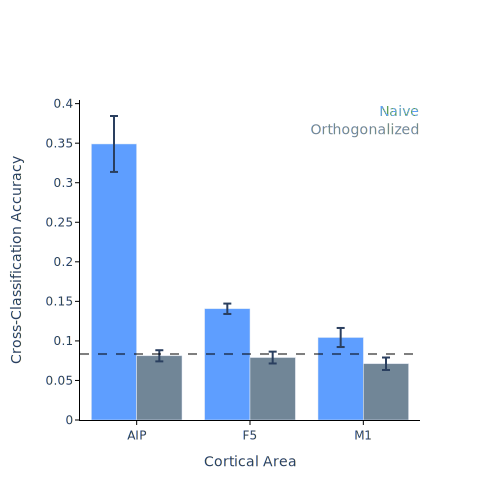

In [10]:
# and plot
fig = go.Figure()
# fig.full_figure_for_development()
fig.add_trace(go.Bar(
    name='Naive',
    marker_color='rgba(26, 118, 255, 0.7)',
    x=[0,1,2], y=mu['naive'].to_list(),
    error_y=dict(type='data', array=se['naive'].to_list())
))
fig.add_trace(go.Bar(
    name='Orthogonalized',
    marker_color='rgba(55, 83, 109, 0.7)',
    x=[0,1,2], y=mu['orthogonalized'].to_list(),
    error_y=dict(type='data', array=se['orthogonalized'].to_list())
))

fig.update_xaxes(ticks='outside',
                           tickwidth=1,
                           tickcolor='black',
                           ticklen=4,
                           linecolor='rgba(0,0,0,1)',
                           linewidth=1,
                           showgrid=False)

fig.update_yaxes(ticks='outside',
                               tickwidth=1,
                               tickcolor='black',
                               ticklen=4,
                               linecolor='rgba(0,0,0,1)',
                               linewidth=1,
                               showgrid=False
                               )

# guess I gotta go low-level for this
fig['layout']['xaxis']['title'] = 'Cortical Area'
fig['layout']['xaxis']['range'] = [-0.5, 2.5]
fig['layout']['yaxis']['title'] = 'Cross-Classification Accuracy'
fig['layout']['xaxis']['ticktext'] = ['AIP','F5','M1']
fig['layout']['xaxis']['tickvals'] = [0,1,2]

fig.add_trace(
    go.Scatter(
        x=[-0.5,2.5],
        y=[df['chance'].mean() for _ in range(2)],
        name='chance',
        mode='lines',
        line={
            'color':f'rgba(0,0,0,0.5)',
            'dash':'dash'
        }
    ),
)

fig.update_layout(barmode='group',
    plot_bgcolor='rgba(0,0,0,0)' ,
    paper_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    autosize=False,
    width=500,
    height=500)

# I also need to do janky things to make a custom legend, too! wow!

colors = ['rgba(26, 118, 255, 0.7)','rgba(55, 83, 109, 0.7)']
prepend=''
for idx,legent in enumerate(['Naive','Orthogonalized']):
    c  = colors[idx]

    fig.add_annotation(xref='x domain',
                                     yref='y domain',
                                     x = 1,
                                     y = 1,
                                     text = prepend+legent,
                                     showarrow=False,
                                     font={
                                         'color':c,
                                         'size':14
                                         },
                                     align='right',
                                     valign='top',
                                     yanchor='top',
                                     xanchor='right')

    prepend+=' <br>' # needs a space
    
fig.show(renderer="svg")
fig.write_image(os.path.join('figs','Vision_Movement_Cross.svg'))

In [11]:
# now, self-classification
selfaccs = dict()

for session in sessions:
    selfaccs[session] = dict()
    
    for area in areas:
        selfaccs[session][area] = dict()
        
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['cue onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','object','grip','turntable','alignment'])
        
        df = dp.readQuery(0)
        df['turntable'] = df['turntable'] // 10
        
        
        df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
        df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0)].groupby(['context','turntable','grip','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
        
        df_vision_trials
        
        # okay, let's iterate through contexts
        for context in ['active','passive']:
            print(f"{session} {area} {context}")
            selfaccs[session][area][context] = dict()
            
            # extract the context (and ignore the special turntable to get your chance level under control... but DO leave it in when estimating the subspace spanned by the object vision repertoire)
            df_movement_context  = df_movement_trials.loc[(df_movement_trials.index.get_level_values(0)==context) & (df_movement_trials.index.get_level_values(1)!=9)] # keep the context multiindex level here, too
            df_vision_context    = df_vision_trials.loc[(df_vision_trials.index.get_level_values(0)==context) & (df_vision_trials.index.get_level_values(1)!=9)] # keep the context multiindex level to enable aggregation after concatenation
            df_vision_offcontext = df_vision_trials.loc[(df_vision_trials.index.get_level_values(0)!=context) |  (df_vision_trials.index.get_level_values(1)==9)]
            
            labels = df_movement_context.index.get_level_values(2)
            
            axesToRemove  = 0
            neurcount     = len(dp.get('neuronColumnNames'))
            pccount       = 30
            nsplits       = 5

            skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
            splits  = skf.split(np.zeros(len(labels)),labels)
            splits  = list(splits) # store as list to allow it to be used many of time
            PCmdls  = []

            # step 1: find the set of axes for each split
            for train_,_ in splits:
                df_vision_cat = pd.concat( (df_vision_context.iloc[train_],df_vision_offcontext) )
                df_vision_agg = df_vision_cat.groupby(level=[1]).aggregate('mean')
                n_components = min(df_vision_agg.shape) - 1
                PCmdl = PCA(n_components=n_components)
                PCmdl.fit(df_vision_agg.to_numpy())
                PCmdls+=[PCmdl]

                # no need for deltamu here

            # step 2: cross-validated model fitting & evaluation
            idx=0
            for axesToRemove in [0,orthocounts[session][area]]:
                correct_count = 0
                chance_count  = 0
                total_count   = len(labels)

                for fold,(train_,test_) in enumerate(splits):
                    trainX = df_movement_context.iloc[train_]
                    trainy = labels[train_].to_numpy()

                    testX  = df_movement_context.iloc[test_]
                    testy  = labels[test_].to_numpy()

                    if axesToRemove > 0:
                        nullSpace = null_space( np.matrix(PCmdls[fold].components_[:axesToRemove,:]) )
                    else:
                        nullSpace = np.eye(neurcount)

                    # projections
                    trainX = trainX.to_numpy() @ nullSpace
                    testX  = testX.to_numpy() @ nullSpace

                    # no deltamu removal needed

                    # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
                    PCmdl = PCA(n_components=pccount)
                    trainX = PCmdl.fit_transform(trainX)
                    testX  = PCmdl.transform(testX)

                    # now we can finally start classifying!
                    LDmdl = LDA()
                    LDmdl.fit(trainX,trainy)
                    yhat = LDmdl.predict(testX)

                    correct_count += np.sum(yhat==testy)
                    chance_count  += len(testy) * max(LDmdl.priors_)

                correct_rate   = correct_count / total_count
                chance_rate    = chance_count / total_count
                threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE

                temp = dict()
                temp['correct_count'] = correct_count
                temp['chance_count']  = chance_count
                temp['total_count']   = total_count
                temp['removed_axes']  = axesToRemove
                temp['neuron_count']  = len(dp.get('neuronColumnNames'))

                if idx==0:
                    selfaccs[session][area][context]['naive'] = temp
                else:
                    selfaccs[session][area][context]['orthogonalized'] = temp

                print(f"    Removed axes = {axesToRemove}")
                print(f"    Number of neurons = {len(dp.get('neuronColumnNames'))}")
                print(f"    Accuracy = {correct_rate}")
                print(f"    Chance = {chance_rate}")
                print(f"    Threshold = {threshold_rate}")
                print()
                idx+=1

Zara64 AIP active
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.6779661016949152
    Chance = 0.22033221083926324
    Threshold = 0.2514857333437951

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.5932203389830508
    Chance = 0.22033221083926324
    Threshold = 0.2514857333437951

Zara64 AIP passive
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.38764044943820225
    Chance = 0.1685492858146759
    Threshold = 0.19660825502560722

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.34269662921348315
    Chance = 0.1685492858146759
    Threshold = 0.19660825502560722

Zara64 F5 active
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.7288135593220338
    Chance = 0.22033221083926324
    Threshold = 0.2514857333437951

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.7457627118644068
    Chance = 0.22033221083926324
    Threshold = 0.2514857333437951

Zara64 F5 passive
    Removed

In [12]:
# prep the data for plotting

# get the data ready for plotting
# x = before
# y = after

pre_     = []
post_    = []
pre_se   = []
post_se  = []
chance   = []
session_ = []
animal   = []
area_    = []
context_ = []

for session in selfaccs:
    for area in selfaccs[session]:
        for context in selfaccs[session][area]:
            temp = selfaccs[session][area][context]
            pre_ +=[temp['naive']['correct_count']/temp['naive']['total_count']]
            post_+=[temp['orthogonalized']['correct_count']/temp['orthogonalized']['total_count']]
            pre_se+=[( pre_[-1]*(1-pre_[-1])/temp['naive']['total_count'] )]
            post_se+=[( post_[-1]*(1-post_[-1])/temp['orthogonalized']['total_count'] )] # keep it squared so you can sum them
            chance+=[temp['naive']['chance_count'] / temp['naive']['total_count']] # chance should be the same across both naive & orthogonalized
            session_+=[session]

            an,_ = mysplit(session)

            animal+=[an]
            area_+=[area]
            context_+=[context]
        
dd = {'naive':pre_,
      'orthogonalized':post_,
      'naive_se2':pre_se,
      'orthogonalized_se2':post_se,
      'chance':chance,
      'session':session_,
      'animal':animal,
      'area':area_,
      'context':context_}

df = pd.DataFrame(dd)

print(df)



mu = df.groupby(['area','context'])[['naive','orthogonalized','naive_se2','orthogonalized_se2']].mean()
se = df.groupby(['area','context'])[['naive','orthogonalized']].sem()
print(mu)
print(se)

       naive  orthogonalized  naive_se2  orthogonalized_se2    chance session  \
0   0.677966        0.593220   0.001233            0.001363  0.220332  Zara64   
1   0.387640        0.342697   0.001334            0.001265  0.168549  Zara64   
2   0.728814        0.745763   0.001117            0.001071  0.220332  Zara64   
3   0.404494        0.432584   0.001353            0.001379  0.168549  Zara64   
4   0.700565        0.666667   0.001185            0.001255  0.220332  Zara64   
5   0.247191        0.219101   0.001045            0.000961  0.168549  Zara64   
6   0.728814        0.605932   0.000837            0.001012  0.169495  Zara70   
7   0.386555        0.310924   0.000996            0.000900  0.126055  Zara70   
8   0.597458        0.588983   0.001019            0.001026  0.169495  Zara70   
9   0.306723        0.294118   0.000893            0.000872  0.126055  Zara70   
10  0.627119        0.627119   0.000991            0.000991  0.169495  Zara70   
11  0.172269        0.172269

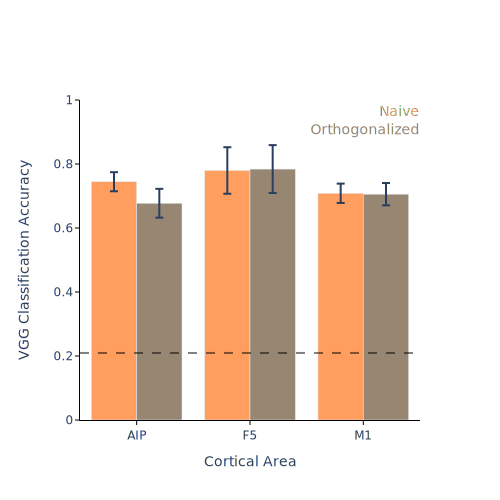

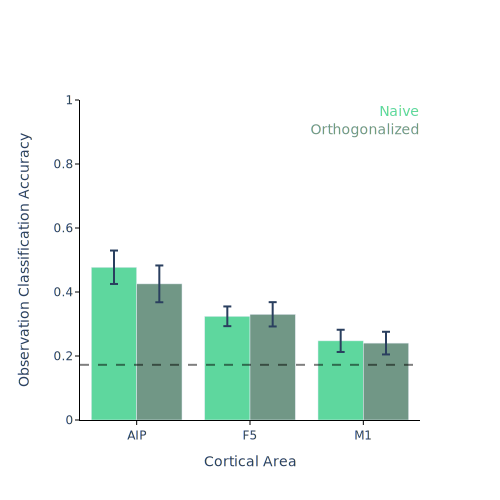

In [13]:
# and plot

# iterate through contexts
truenames  = ['VGG','Observation']
truecolors = [['rgba(255, 118, 26, 0.7)','rgba(109, 83, 55, 0.7)'],
              ['rgba(26, 200, 118, 0.7)','rgba(55, 109, 83, 0.7)']]
for idx,context in enumerate(['active','passive']):
    fig = go.Figure()
    # fig.full_figure_for_development()
    fig.add_trace(go.Bar(
        name='Naive',
        marker_color=truecolors[idx][0],
        x=[0,1,2], y=mu['naive'].loc[:,context].to_list(),
        error_y=dict(type='data', array=se['naive'].loc[:,context].to_list())
    ))
    fig.add_trace(go.Bar(
        name='Orthogonalized',
        marker_color=truecolors[idx][1],
        x=[0,1,2], y=mu['orthogonalized'].loc[:,context].to_list(),
        error_y=dict(type='data', array=se['orthogonalized'].loc[:,context].to_list())
    ))

    fig.update_xaxes(ticks='outside',
                               tickwidth=1,
                               tickcolor='black',
                               ticklen=4,
                               linecolor='rgba(0,0,0,1)',
                               linewidth=1,
                               showgrid=False)

    fig.update_yaxes(ticks='outside',
                                   tickwidth=1,
                                   tickcolor='black',
                                   ticklen=4,
                                   linecolor='rgba(0,0,0,1)',
                                   linewidth=1,
                                   showgrid=False
                                   )

    # guess I gotta go low-level for this
    fig['layout']['xaxis']['title'] = 'Cortical Area'
    fig['layout']['xaxis']['range'] = [-0.5, 2.5]
    fig['layout']['yaxis']['title'] = f'{truenames[idx]} Classification Accuracy'
    fig['layout']['yaxis']['range'] = [0, 1]
    fig['layout']['xaxis']['ticktext'] = ['AIP','F5','M1']
    fig['layout']['xaxis']['tickvals'] = [0,1,2]

    fig.add_trace(
        go.Scatter(
            x=[-0.5,2.5],
            y=[df['chance'].loc[df['context']==context].mean() for _ in range(2)],
            name='chance',
            mode='lines',
            line={
                'color':f'rgba(0,0,0,0.5)',
                'dash':'dash'
            }
        ),
    )

    fig.update_layout(barmode='group',
        plot_bgcolor='rgba(0,0,0,0)' ,
        paper_bgcolor='rgba(0,0,0,0)',
        showlegend=False,
        autosize=False,
        width=500,
        height=500)

    # I also need to do janky things to make a custom legend, too! wow!

    colors = truecolors[idx]
    prepend=''
    for idx_,legent in enumerate(['Naive','Orthogonalized']):
        c  = colors[idx_]

        fig.add_annotation(xref='x domain',
                                         yref='y domain',
                                         x = 1,
                                         y = 1,
                                         text = prepend+legent,
                                         showarrow=False,
                                         font={
                                             'color':c,
                                             'size':14
                                             },
                                         align='right',
                                         valign='top',
                                         yanchor='top',
                                         xanchor='right')

        prepend+=' <br>' # needs a space

    fig.show(renderer="svg")
    fig.write_image(os.path.join('figs',f'{truenames[idx]}_Self.svg'))

# Decoding time 
- as in, performing regression to estimate the time relative to movement & hold onset from neural activity
- then doing CROSS-DECODING to prove it's shared across contexts

In [ ]:
# grab the data
# do I *really* need to orthogonalize w.r.t. object vision? My control analyses suggest that it's actually not that big a deal...
# For this analysis, no. 
# In fact, for the grip classification stuff, you can *also* skip it.
# BUT. When it comes to the subspace alignment stuff, you ABSOLUTELY should orthogonalize, because you know it CAN be cross-decoded! (At least in AIP). Which means it CAN inflate the apparent alignment across the contexts, even if it's not affecting raw accuracy per se!

# Appendix: ChatGPT-generated barplot

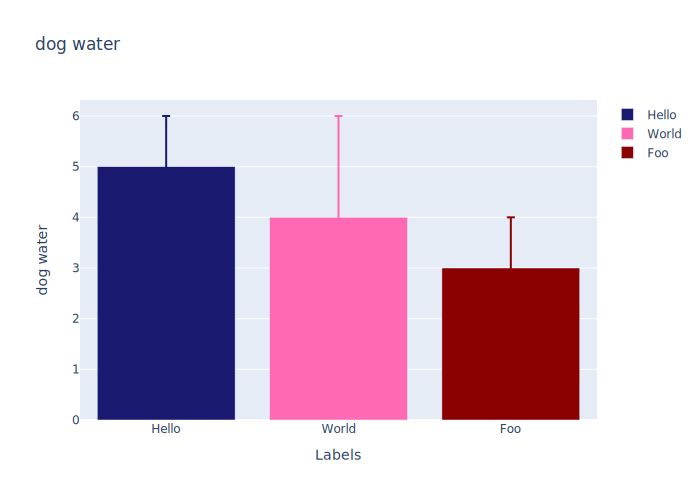

In [14]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Hello', x=['Hello'], y=[5], error_y=dict(type='data', array=[1], color='midnightblue'), marker_color='midnightblue'),
    go.Bar(name='World', x=['World'], y=[4], error_y=dict(type='data', array=[2], color='hotpink'), marker_color='hotpink'),
    go.Bar(name='Foo', x=['Foo'], y=[3], error_y=dict(type='data', array=[1], color='darkred'), marker_color='darkred')
])

fig.update_layout(title='dog water', xaxis_title='Labels', yaxis_title='dog water')

fig.show(renderer="svg")